Epoch 1/100
250/250 [==============================] - 63s 225ms/step - loss: 0.1186 - val_loss: 0.0523
Epoch 2/100
250/250 [==============================] - 42s 169ms/step - loss: 0.0298 - val_loss: 0.0239
Epoch 3/100
250/250 [==============================] - 44s 176ms/step - loss: 0.0227 - val_loss: 0.0221
Epoch 4/100
250/250 [==============================] - 42s 169ms/step - loss: 0.0214 - val_loss: 0.0207
Epoch 5/100
250/250 [==============================] - 43s 174ms/step - loss: 0.0208 - val_loss: 0.0208
Epoch 6/100
250/250 [==============================] - 42s 168ms/step - loss: 0.0202 - val_loss: 0.0207
Epoch 7/100
250/250 [==============================] - 42s 168ms/step - loss: 0.0201 - val_loss: 0.0203
Epoch 8/100
250/250 [==============================] - 44s 174ms/step - loss: 0.0200 - val_loss: 0.0199
Epoch 9/100
250/250 [==============================] - 42s 169ms/step - loss: 0.0197 - val_loss: 0.0195
Epoch 10/100
250/250 [==============================] - 43s 173m

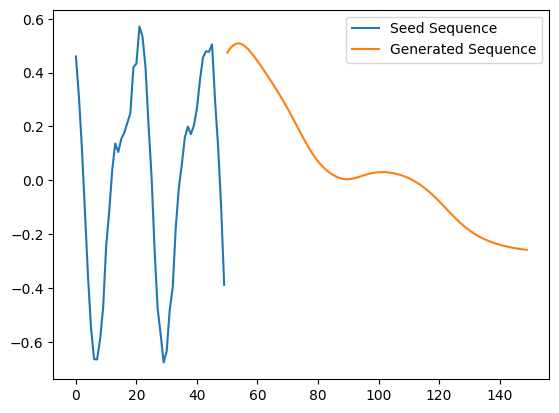

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, callbacks

# Generate sample time-series data
def generate_time_series_data(n, timesteps):
    freq1, freq2, offset1, offset2 = np.random.rand(4, n, 1)
    time = np.linspace(0, 1, timesteps)
    series = 0.5 * np.sin((time - offset1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offset2) * (freq2 * 20 + 20))  # + wave 2
    series += 0.1 * (np.random.rand(n, timesteps) - 0.5)          # + noise
    return series[..., np.newaxis].astype(np.float32)

# Create autoencoder model
def create_autoencoder(timesteps):
    input_seq = layers.Input(shape=(timesteps, 1))
    encoded = layers.LSTM(128, return_sequences=True)(input_seq)
    encoded = layers.LSTM(64, return_sequences=False)(encoded)
    decoded = layers.RepeatVector(timesteps)(encoded)
    decoded = layers.LSTM(64, return_sequences=True)(decoded)
    decoded = layers.LSTM(128, return_sequences=True)(decoded)
    decoded = layers.TimeDistributed(layers.Dense(1))(decoded)
    autoencoder = models.Model(input_seq, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Train autoencoder model
def train_autoencoder(autoencoder, X_train, X_valid, epochs):
    early_stopping = callbacks.EarlyStopping(patience=10)
    history = autoencoder.fit(X_train, X_train, epochs=epochs, validation_data=(X_valid, X_valid),
                              callbacks=[early_stopping])
    return history

# Generate new sequence using trained autoencoder
def generate_new_sequence(autoencoder, seed_sequence, future_steps):
    sequence = autoencoder.predict(seed_sequence[np.newaxis, ...])
    for _ in range(future_steps - 1):
        sequence = np.concatenate([sequence, autoencoder.predict(sequence[-1][np.newaxis, ...])], axis=0)
    return sequence

# Main function
def main():
    np.random.seed(42)
    timesteps = 50
    n_samples = 10000
    series = generate_time_series_data(n_samples, timesteps)

    # Split data into training and validation sets
    split_time = int(n_samples * 0.8)
    X_train, X_valid = series[:split_time], series[split_time:]

    # Create and train autoencoder model
    autoencoder = create_autoencoder(timesteps)
    history = train_autoencoder(autoencoder, X_train, X_valid, epochs=100)

    # Generate new sequence
    seed_sequence = series[0]
    future_steps = 100
    new_sequence = generate_new_sequence(autoencoder, seed_sequence, future_steps)

    # Plot results
    plt.plot(np.arange(timesteps), seed_sequence, label='Seed Sequence')
    plt.plot(np.arange(timesteps, timesteps + future_steps), new_sequence[:, 0], label='Generated Sequence')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
